In [1]:
from game import Game
from test import Test
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Bernoulli
import copy

In [45]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(256, 4)

        # self.fc1 = nn.Linear(256, 256)
        # self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        # x = nn.Softmax(dim=0)(self.fc1(x))
        x = torch.sigmoid(self.fc1(x))


        # x = F.relu(self.fc1(x))
        # x = nn.Softmax(dim=0)(self.fc2(x))
        return x

In [46]:
def validate(model, n = 10, max_step = -1):
    history = []
    with torch.no_grad():
        for i in range(n):
            g = Game()
            g.generate_number()
            g.generate_number()
            while not g.lose and max_step != 0:
                max_step -= 1
                st = model(torch.FloatTensor(g.one_hot_field().reshape([-1])))
                g.step(st.numpy())
            else:
                history.append([i, g.score, g.lose])
    return np.array(history)[:,1].mean(), np.array(history)[:,2].sum()

In [64]:
num_episode = 500
batch_size = 1
learning_rate = 0.003
gamma = 0.99
count = 400
count_step_between_val = 10
count_play_per_val = 10

policy_net = PolicyNet()
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=learning_rate)

# Batch History
state_pool = []
action_pool = []
reward_pool = []
loses = []
validates = []

for e in tqdm(range(num_episode)):
    steps = 0
    game = Game()
    game.generate_number()
    game.generate_number()
    state = game.one_hot_field().reshape([1,-1])
    state = torch.from_numpy(state).float()

    for t in range(count):
        action = policy_net(state)[0]
        with torch.no_grad():
            next_state, reward, done = game.step(action.numpy())
        # reward = 0
        if done:
            reward = -1000

        state_pool.append(state)
        action_pool.append(action)
        reward_pool.append(reward)

        state = next_state.reshape([1,-1])
        state = torch.from_numpy(state).float()

        steps += 1

        if done:
            break

    # Update policy
    if e % batch_size == 0:

        running_add = 0
        for i in reversed(range(steps)):
            running_add = running_add * gamma + reward_pool[i]
            reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(steps):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        # Gradient Desent
        optimizer.zero_grad()

        temp_loss = 0
        for i in range(steps):
            state = state_pool[i]
            action = action_pool[i].reshape(1,-1)
            reward = reward_pool[i]

            loss = -(torch.log(action + 0.000001) * reward).sum()
            with torch.no_grad():
                temp_loss += loss.item()
            # print('loss:', loss.item())
            loss.backward()
        temp_loss /= steps
        loses.append(temp_loss)
        optimizer.step()
        if e % count_step_between_val == 0:
            validates.append(validate(policy_net, max_step=count, n=count_play_per_val))
        state_pool = []
        action_pool = []
        reward_pool = []


100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


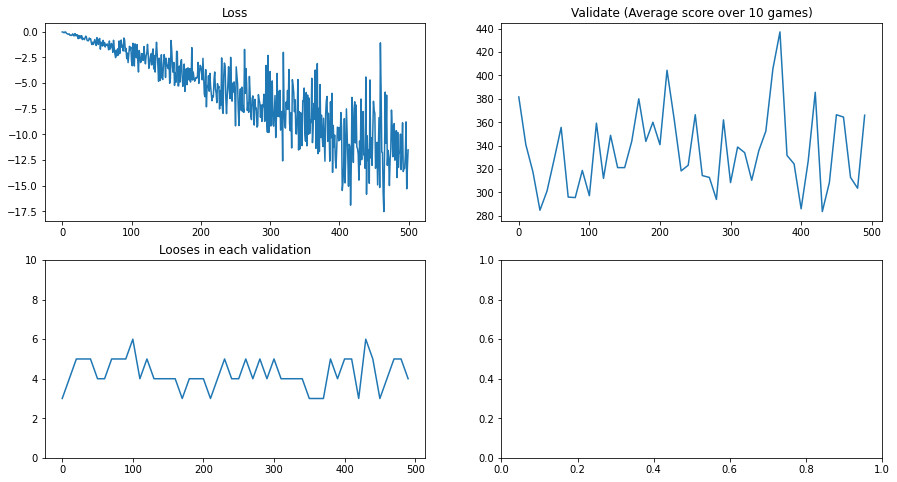

In [65]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 8)
axs[0,0].title.set_text('Loss')
axs[0,0].plot(loses)
axs[0,1].title.set_text(f'Validate (Average score over {count_play_per_val} games)')
axs[0,1].plot(list(range(0,num_episode,count_step_between_val)), np.array(validates)[:,0])
axs[1,0].title.set_text('Looses in each validation')
axs[1,0].set_ylim([0, count_play_per_val])
axs[1,0].plot(list(range(0,num_episode,count_step_between_val)), np.array(validates)[:,1])


In [13]:
np.random.seed(0)

if __name__ == '__main__':
    Test(Game)
    history = []
    with torch.no_grad():
        for i in tqdm(range(200)):
            g = Game()
            g.generate_number()
            g.generate_number()
            while not g.lose:
                st = policy_net(torch.FloatTensor(g.field.flatten()))
                g.step(st.numpy())
            else:
                history.append([i, g.score])

Test 1 OK
Test 2 OK
Test 3 OK
Test 4 OK
Test 5 OK


100%|██████████| 200/200 [00:02<00:00, 70.47it/s]


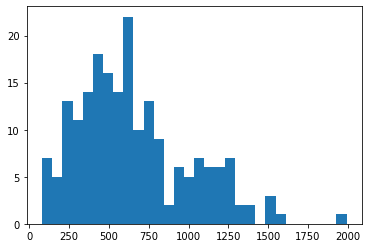

In [14]:
data = pd.DataFrame(history)
plt.hist(data[1], bins=30);

In [161]:
F.one_hot(torch.tensor([0,11,1,1,2]), num_classes=10)

RuntimeError: Class values must be smaller than num_classes.

In [16]:
data[1].describe()

count     200.0000
mean      651.8800
std       352.1112
min        80.0000
25%       397.0000
50%       596.0000
75%       838.0000
max      1992.0000
Name: 1, dtype: float64

In [22]:
data[1].describe()

count    10000.000000
mean       968.150000
std        493.050405
min         48.000000
25%        596.000000
50%        904.000000
75%       1256.000000
max       3656.000000
Name: 1, dtype: float64